<a href="https://colab.research.google.com/github/YoonHyeJu/project1/blob/master/transfer_learning_catdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from keras.preprocessing.image import load_img

In [4]:
PATH = '/content/gdrive/My Drive/Colab Notebooks/cats_dogs/'

In [5]:
train_data_dir = PATH + 'train/'
validation_data_dir = PATH + 'validation/'
test_data_dir = PATH + 'test/'

In [6]:
train_dog_dir = train_data_dir + 'dog/'
train_cat_dir = train_data_dir + 'cat/'

validation_dog_dir = validation_data_dir + 'dog/'
validation_cat_dir = validation_data_dir + 'cat/'

test_dog_dir = test_data_dir + 'dog/'
test_cat_dir = test_data_dir + 'cat/'

In [7]:
train_size, validation_size, test_size = 200, 100, 100

img_width, img_height = 224, 224

In [8]:
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

In [9]:
def show_pictures(PATH):
    random_img = random.choice(os.listdir(PATH))
    img_path = os.path.join(PATH, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)
    img_tensor = img_tensor/255.
    plt.imshow(img_tensor)
    plt.show()

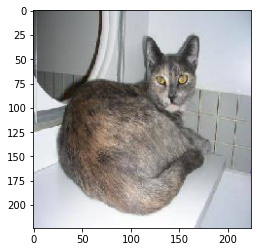

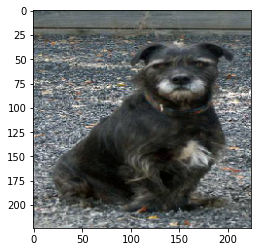

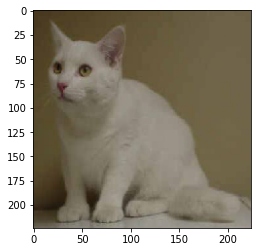

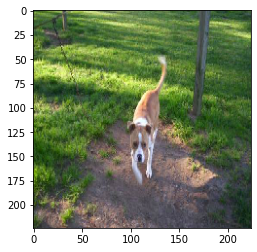

In [10]:
for i in range(0,2):
    show_pictures(train_cat_dir)
    show_pictures(train_dog_dir)

In [11]:
from keras.applications import VGG16

In [12]:
conv_base = VGG16(weights = 'imagenet', include_top= False, input_shape=(img_width, img_height, 3)) # include_top: 상단의 레이어를 포함할 것인지 아닌지 결정하는 파라미터

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

In [15]:
datagen = ImageDataGenerator(rescale=1/255.)
batch_size = 32

In [16]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count,7,7,512))
    labels = np.zeros(shape=(sample_count))

    generator = datagen.flow_from_directory(directory, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary')

    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i+=1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [17]:
train_features, train_labels = extract_features(train_data_dir, train_size)
validation_features, validation_labels = extract_features(validation_data_dir, validation_size)
test_features, test_labels = extract_features(test_data_dir, test_size)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [18]:
print(train_features)
print(train_labels)

[[[[0.2048018  0.         0.42239839 ... 0.         0.46180618
    0.        ]
   [0.         0.         0.         ... 0.         0.48224044
    0.        ]
   [0.         0.         0.         ... 0.         0.83874357
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.83449972
    0.        ]
   [0.         0.         0.         ... 0.         0.90198976
    0.        ]
   [0.02456772 0.         0.01388949 ... 0.         0.84700942
    0.        ]]

  [[1.05417347 0.         0.         ... 0.         0.48178077
    0.        ]
   [0.41031748 0.         0.         ... 0.         0.56645477
    0.        ]
   [0.         0.         0.40617034 ... 0.         0.57791573
    0.        ]
   ...
   [0.         0.         0.66467935 ... 0.         0.40818346
    0.        ]
   [0.47397858 0.         0.37830794 ... 0.         0.85333407
    0.        ]
   [0.9446497  0.         0.         ... 0.         1.12428403
    0.        ]]

  [[0.85052091 0.         0.412201

**Fully Connected**

In [19]:
from keras import models
from keras import layers
from keras import optimizers

In [20]:
epochs = 100

In [21]:
model = models.Sequential()
model.add(layers.Flatten(input_shape = (7,7,512)))
model.add(layers.Dense(256, activation='relu',input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer=optimizers.Adam(), loss = 'binary_crossentropy', metrics=['acc'])

In [23]:
history = model.fit(train_features, train_labels, epochs = epochs, batch_size=batch_size, validation_data=(validation_features, validation_labels))

Epoch 1/100
7/7 [==============================] - 0s 33ms/step - loss: 2.5728 - acc: 0.5250 - val_loss: 1.2593 - val_acc: 0.5300
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7037 - acc: 0.7250 - val_loss: 0.7766 - val_acc: 0.6900
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.4800 - acc: 0.8150 - val_loss: 0.6864 - val_acc: 0.6600
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.1671 - acc: 0.9200 - val_loss: 0.4786 - val_acc: 0.7900
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 0.1988 - acc: 0.9300 - val_loss: 0.2785 - val_acc: 0.8700
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.2007 - acc: 0.9250 - val_loss: 0.2567 - val_acc: 0.9300
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0817 - acc: 0.9800 - val_loss: 0.2628 - val_acc: 0.8700
Epoch 8/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0545 - acc: 0.98

In [24]:
model.save('dog_cat_fcl.h5')

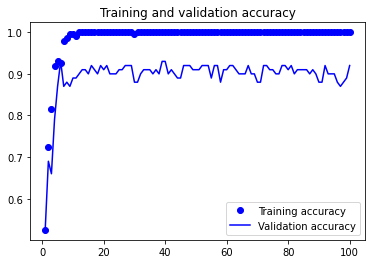

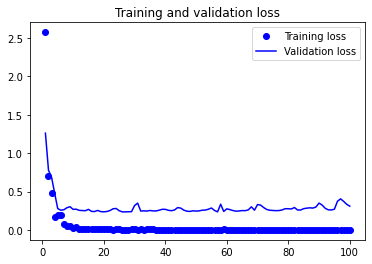

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
def visualize_predictoins(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_cat_dir, test_dog_dir])

        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)
        img_tensor /= 255.

        features = conv_base.predict(img_tensor.reshape(1, img_width, img_height, 3))

        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(featues.reshape(1, 7*7*512))

        plt.imshow(img_tensor)
        plt.show()

        if prediction < 0.5:
            print('Cat')
        else:
            print('Dog')

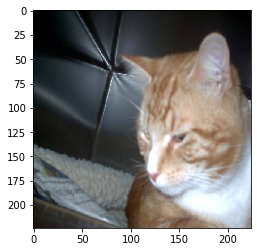

Cat


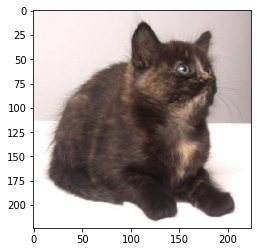

Cat


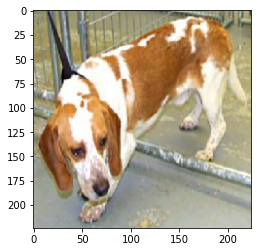

Dog


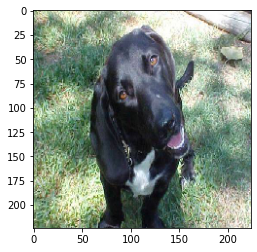

Dog


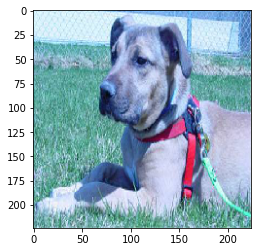

Dog


In [27]:
visualize_predictoins(model, 5)

**Global average pooling**

In [28]:
from keras import models
from keras import layers
from keras import optimizers

In [29]:
epochs = 100

In [30]:
model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer = optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])

In [32]:
history = model.fit(train_features, train_labels,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (validation_features, validation_labels))

Epoch 1/100
7/7 [==============================] - 0s 24ms/step - loss: 0.6987 - acc: 0.5150 - val_loss: 0.6801 - val_acc: 0.5300
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6829 - acc: 0.5650 - val_loss: 0.6735 - val_acc: 0.5600
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6734 - acc: 0.5650 - val_loss: 0.6652 - val_acc: 0.6300
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6639 - acc: 0.6550 - val_loss: 0.6572 - val_acc: 0.6900
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6558 - acc: 0.7200 - val_loss: 0.6520 - val_acc: 0.6700
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6499 - acc: 0.7350 - val_loss: 0.6440 - val_acc: 0.7200
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6397 - acc: 0.7850 - val_loss: 0.6360 - val_acc: 0.7500
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6352 - acc: 0.7100 - va

In [33]:
model.save('dog_cat_gap.h5')

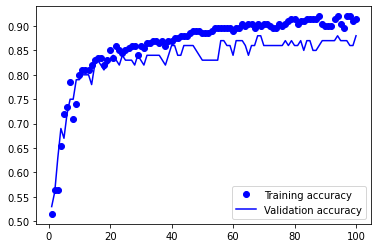

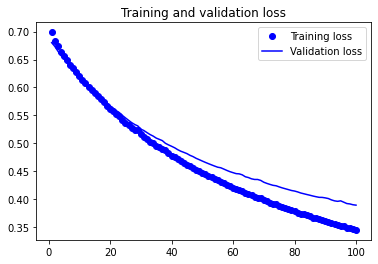

In [34]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

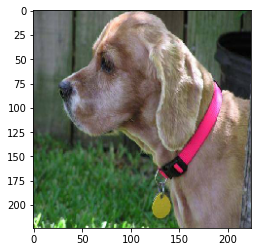

Dog


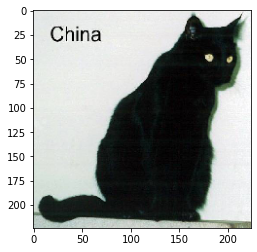

Dog


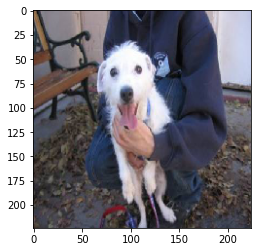

Dog


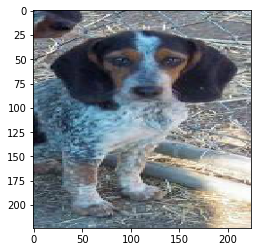

Dog


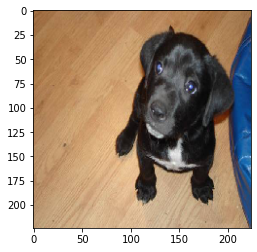

Dog


In [35]:
visualize_predictoins(model, 5)

**Linear support vector machines**

In [36]:
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [37]:
import sklearn

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [39]:
X_train, y_train = svm_features.reshape(300,7*7*512), svm_labels

param = [{"C": [0.01, 0.1, 1, 10, 100] }]

svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [40]:
model.save('dog_cat_svm.h5')

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [42]:
print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
print("\nAccuracy score (standard deviation):")
print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


KeyboardInterrupt: ignored

In [44]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

KeyboardInterrupt: ignored

In [47]:
visualize_predictions(clf, 5)

NameError: ignored